# Psychedelic experience data

Correlations among experience data and microstate statistics

In [40]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display
from scipy.stats import pearsonr, spearmanr

from src.helpers import DATA_ROOT, PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.rcParams["figure.figsize"] = (20, 9)
# plt.style.use("default_light")

MS_STATS_ROOT = os.path.join(RESULTS_ROOT, "microstates")
WORKING_DIR = os.path.join(RESULTS_ROOT, "experience")
if not os.path.exists(WORKING_DIR):
    make_dirs(WORKING_DIR)
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "experience")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = False
PLOT_EXT = ".png"

In [66]:
experience = pd.read_csv(
    os.path.join(DATA_ROOT, "experience_data", "experience_processed.csv")
)
experience = experience.rename(columns={"group": "condition"})

ms_stats = pd.read_csv(os.path.join(MS_STATS_ROOT, "ms_stats.csv"), index_col=[0])
# divide session into PLA/PSI and time for plotting purposes
ms_stats[["condition", "time"]] = ms_stats["session"].str.split("-", expand=True)
# divide to filters
ms_stats_220 = ms_stats[ms_stats["ms_opts"] == "(2.0, 20.0, 4)"]
ms_stats_220 = ms_stats_220.sort_values(by=["condition", "time"])
ms_stats_140 = ms_stats[ms_stats["ms_opts"] == "(1.0, 40.0, 3)"]
ms_stats_140 = ms_stats_140.sort_values(by=["condition", "time"])

In [48]:
def plot_corr(df, method="pearson", mask_upper=True, mask_pval=True, fname=None):
    plt.figure(figsize=(16, 14))
    corr = df.corr(method=method)

    def pval_func(x, y):
        if method == "pearson":
            return pearsonr(x, y)[1]
        elif method == "spearman":
            return spearmanr(x, y)[1]

    pval = df.corr(method=pval_func)
    mask_up = (
        np.triu(np.ones_like(corr, dtype=bool))
        if mask_upper
        else np.zeros_like(corr, dtype=bool)
    )
    mask_pval = pval > 0.05 if mask_pval else np.zeros_like(corr, dtype=bool)
    mask = np.logical_or(mask_up, mask_pval)
    sns.heatmap(
        corr,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        mask=mask,
        fmt=".2f",
        cbar_kws={"shrink": 0.5},
    )
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(PLOTTING_DIR, f"{fname}_{method}_correlation{PLOT_EXT}"),
            bbox_inches="tight",
            transparent=True,
        )
        p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t]))
        corr = corr.round(5).astype(str) + p
        corr.to_csv(os.path.join(WORKING_DIR, f"{fname}_{method}_correlation.csv"))

## Correlations within experience data

### Only psilocybin condition

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


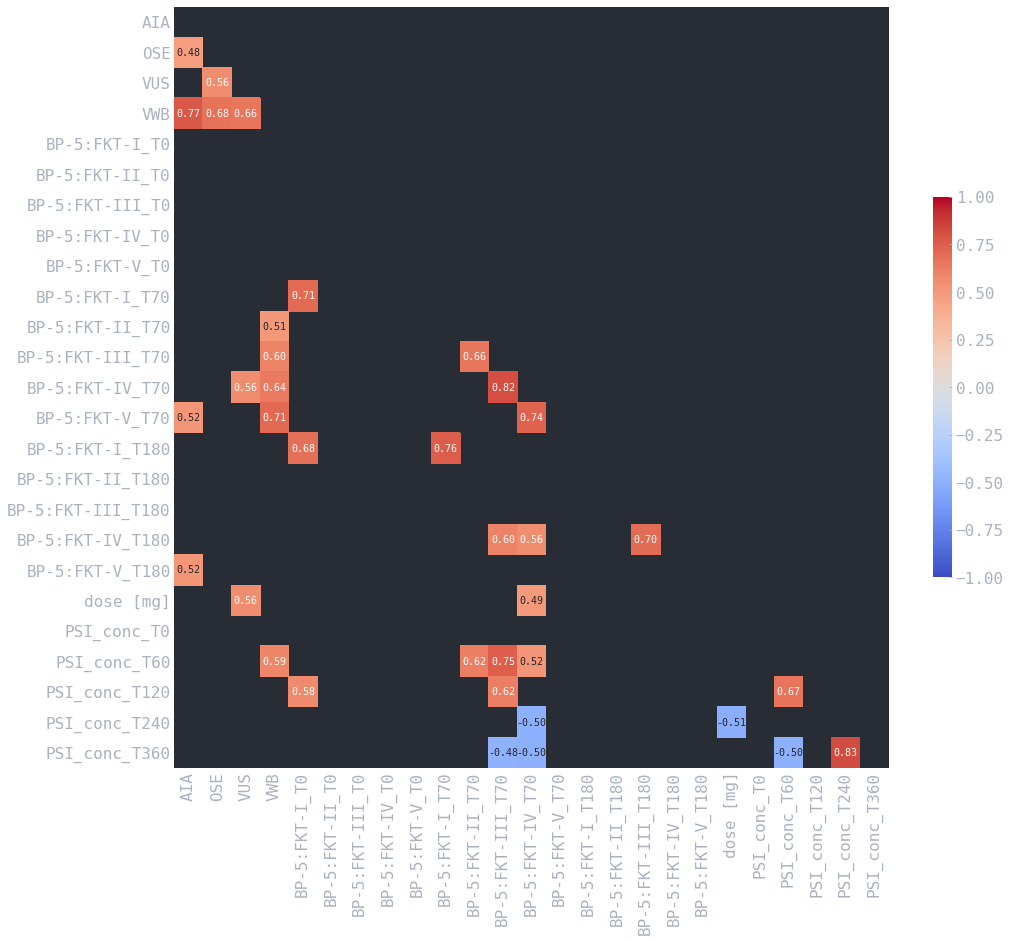

In [53]:
# only pval <= 0.05 unmasked
plot_corr(
    experience[experience["condition"] == "PSI"].drop("subject", axis=1),
    mask_upper=True,
    mask_pval=True,
    method="spearman",
    fname="experience_PSIonly",
)

### Both psilocybin and placebo conditions

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


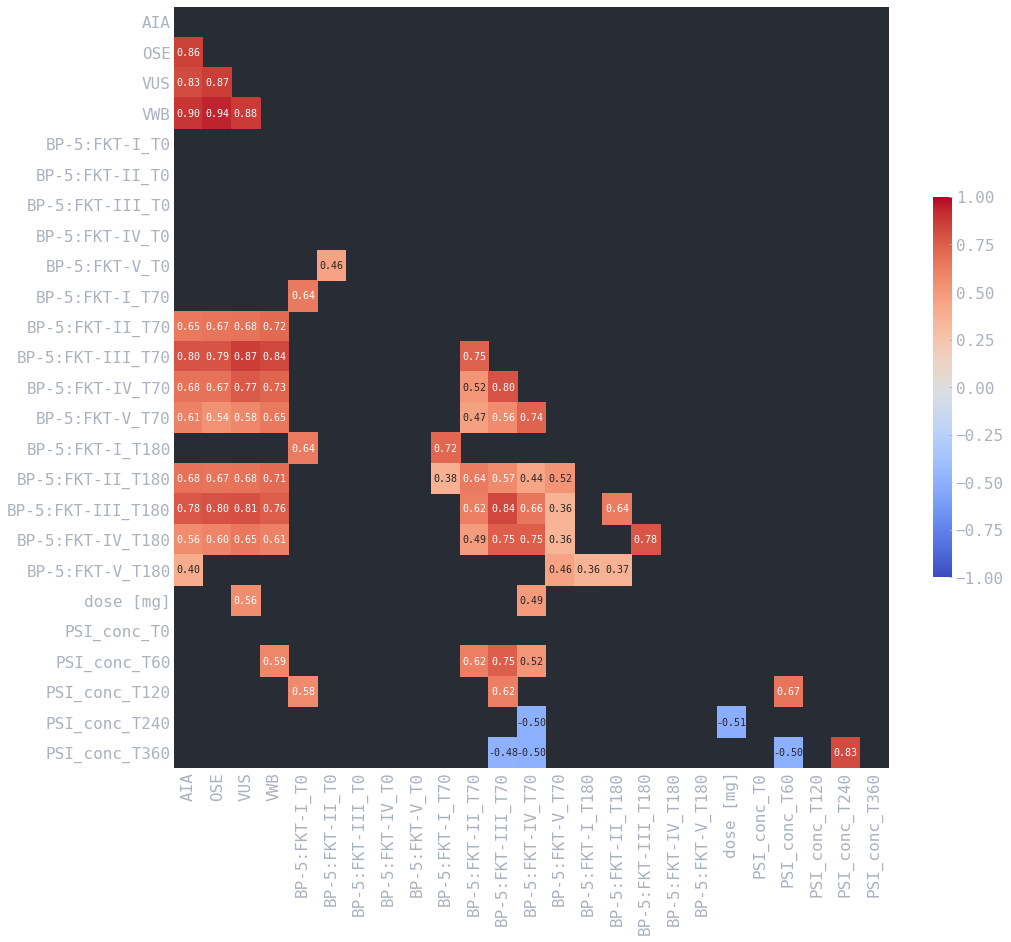

In [54]:
# only pval <= 0.05 unmasked
plot_corr(
    experience.drop("subject", axis=1),
    mask_upper=True,
    mask_pval=True,
    method="spearman",
    fname="experience_PLAandPSI",
)

## Correlations with ASC questionnaire

In [90]:
ASC = ["AIA", "OSE", "VUS", "VWB"]

experience_asc = experience[["subject", "condition"] + ASC]
# match subjects
experience_asc = experience_asc.loc[experience_asc["subject"].isin(ms_stats["subject"])]

In [108]:
grand = pd.DataFrame([])
for ms in np.unique(ms_stats_140["microstate"]):
    asc_corrs = pd.concat(
        [
            ms_stats_140[
                (ms_stats_140["condition"] == "PSI")
                & (ms_stats_140["microstate"] == ms)
                & (ms_stats_140["time"] == "T3")
            ]
            .set_index("subject")
            .corrwith(
                experience_asc[experience_asc["condition"] == "PSI"].set_index("subject")[
                    asc
                ]
            )
            for asc in ASC
        ],
        axis=1,
    )
    asc_corrs.columns = ASC
    asc_corrs["microstate"] = ms
    asc_corrs["time"] = "T3"
    asc_corrs = asc_corrs.dropna()
    asc_corrs.index = asc_corrs.index.rename("stat")
    asc_corrs = asc_corrs.set_index(["time", "microstate", asc_corrs.index])
    grand = pd.concat([grand, asc_corrs], axis=0)

<AxesSubplot:ylabel='time-microstate-stat'>

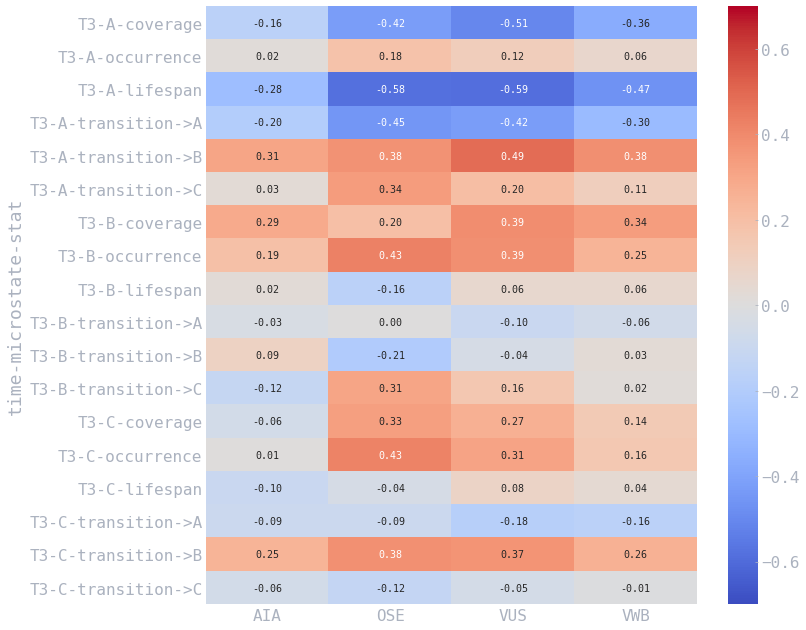

In [112]:
plt.figure(figsize=(11, 11))
sns.heatmap(grand, cmap="coolwarm", annot=True, vmin=-0.7, vmax=0.7, fmt=".2f")